# Hierarchical DivNoising - Prediction
This notebook contains an example on how to use a previously trained Hierarchical DivNoising model to denoise images.
If you haven't done so please first run '1-CreateNoiseModel.ipynb' and '2-Training.ipynb' notebooks.

In [1]:
# We import all our dependencies.
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.optimizer import Optimizer

import sys
sys.path.append('../../../')

from models.lvae import LadderVAE
from boilerplate import boilerplate
import lib.utils as utils
import training

import os
import glob
import zipfile
import urllib
from tifffile import imread, imsave
from matplotlib import pyplot as plt
from tqdm import tqdm

import cv2

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Load noisy test data
The GT test data (```signal```) is created by averaging the noisy images (```observations```).

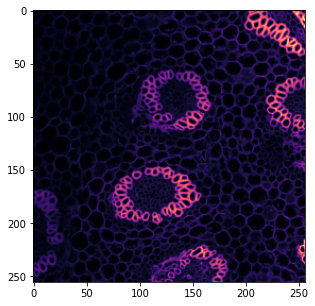

In [3]:
path="./data/Convallaria_diaphragm/"

# The test data is just one quater of the full image ([:,:512,:512]) following the works which have used this data earlier
observation_before= imread(path+'20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif').astype(np.float32)[:,:512,:512]
observation = np.zeros((observation_before.shape[0], 256, 256))
for i in range(observation_before.shape[0]):
    observation[i] = cv2.resize(observation_before[i], (256, 256))
signal=np.mean(observation[:,...],axis=0)[np.newaxis,...]
img_width, img_height = signal.shape[1], signal.shape[2]

plt.figure(figsize=(15, 5))
plt.imshow(signal[0],cmap='magma')

# Load our model

In [4]:
%%capture
model = torch.load("./Trained_model/model/convallaria_last_vae.net")
model.mode_pred=True
model.eval()

# Compute PSNR
The higher the PSNR, the better the denoising performance is.
PSNR is computed using the formula: 

```PSNR = 20 * log(rangePSNR) - 10 * log(mse)``` <br> 
where ```mse = mean((gt - img)**2)```, ```gt``` is ground truth image and ```img``` is the prediction from HDN. All logarithms are with base 10.<br>
rangePSNR = max(```gt```)-min(```gt```) for as used in this [paper](https://ieeexplore.ieee.org/abstract/document/9098612/).

In [5]:
gaussian_noise_std = None
num_samples = 100 # number of samples used to compute MMSE estimate
tta = False # turn on test time augmentation when set to True. It may improve performance at the expense of 8x longer prediction time
psnrs = []
range_psnr = np.max(signal[0])-np.min(signal[0])
for i in range(observation.shape[0]):
    observation[i] = cv2.resize(observation[i], (256, 256))
    img_mmse, samples = boilerplate.predict(observation[i],num_samples,model,gaussian_noise_std,device,tta)
    psnr = utils.PSNR(signal[0], img_mmse, range_psnr)
    psnrs.append(psnr)
    print("image:", i, "PSNR:", psnr, "Mean PSNR:", np.mean(psnrs))

  3%|▎         | 3/100 [00:00<00:04, 22.57it/s]

image: 0 PSNR: 31.798446911598035 Mean PSNR: 31.798446911598035


  3%|▎         | 3/100 [00:00<00:04, 22.56it/s]

image: 1 PSNR: 31.83978118666647 Mean PSNR: 31.819114049132253


  3%|▎         | 3/100 [00:00<00:04, 22.73it/s]

image: 2 PSNR: 31.83628199960898 Mean PSNR: 31.824836699291165


  3%|▎         | 3/100 [00:00<00:04, 23.18it/s]

image: 3 PSNR: 31.971548266430773 Mean PSNR: 31.861514591076066


  3%|▎         | 3/100 [00:00<00:04, 22.43it/s]

image: 4 PSNR: 31.983921756571526 Mean PSNR: 31.88599602417516


  3%|▎         | 3/100 [00:00<00:04, 24.09it/s]

image: 5 PSNR: 31.915766460002217 Mean PSNR: 31.890957763479673


  3%|▎         | 3/100 [00:00<00:04, 23.77it/s]

image: 6 PSNR: 31.93071843215904 Mean PSNR: 31.896637859005295


  3%|▎         | 3/100 [00:00<00:04, 22.37it/s]

image: 7 PSNR: 31.901566262068663 Mean PSNR: 31.897253909388212


  3%|▎         | 3/100 [00:00<00:04, 22.56it/s]

image: 8 PSNR: 31.96279171560007 Mean PSNR: 31.9045358878562


  3%|▎         | 3/100 [00:00<00:04, 22.47it/s]

image: 9 PSNR: 31.879731356775608 Mean PSNR: 31.90205543474814


  3%|▎         | 3/100 [00:00<00:04, 22.71it/s]

image: 10 PSNR: 31.98680385372652 Mean PSNR: 31.909759836473448


  3%|▎         | 3/100 [00:00<00:04, 22.63it/s]

image: 11 PSNR: 31.971625211832375 Mean PSNR: 31.914915284420022


  3%|▎         | 3/100 [00:00<00:04, 22.39it/s]

image: 12 PSNR: 31.952273117815366 Mean PSNR: 31.917788963911974


  3%|▎         | 3/100 [00:00<00:04, 22.91it/s]

image: 13 PSNR: 31.887069833742245 Mean PSNR: 31.915594740328423


  3%|▎         | 3/100 [00:00<00:04, 22.80it/s]

image: 14 PSNR: 31.897072649534906 Mean PSNR: 31.91435993427552


  3%|▎         | 3/100 [00:00<00:04, 22.37it/s]

image: 15 PSNR: 31.865844311068862 Mean PSNR: 31.9113277078251


  3%|▎         | 3/100 [00:00<00:04, 22.63it/s]

image: 16 PSNR: 32.012647409199744 Mean PSNR: 31.917287690258906


  3%|▎         | 3/100 [00:00<00:04, 22.55it/s]

image: 17 PSNR: 31.813344306741918 Mean PSNR: 31.911513057841294


  3%|▎         | 3/100 [00:00<00:04, 22.71it/s]

image: 18 PSNR: 32.012686861460075 Mean PSNR: 31.916837994873863


  3%|▎         | 3/100 [00:00<00:04, 22.50it/s]

image: 19 PSNR: 31.852626815130456 Mean PSNR: 31.91362743588669


  3%|▎         | 3/100 [00:00<00:04, 22.51it/s]

image: 20 PSNR: 32.02444643693063 Mean PSNR: 31.918904531174494


  3%|▎         | 3/100 [00:00<00:04, 22.54it/s]

image: 21 PSNR: 31.80791041761274 Mean PSNR: 31.913859344194417


  3%|▎         | 3/100 [00:00<00:04, 22.34it/s]

image: 22 PSNR: 31.912518074608315 Mean PSNR: 31.913801028125455


  3%|▎         | 3/100 [00:00<00:04, 22.55it/s]

image: 23 PSNR: 31.97202733674029 Mean PSNR: 31.916227124317743


  3%|▎         | 3/100 [00:00<00:04, 22.42it/s]

image: 24 PSNR: 31.941630547687865 Mean PSNR: 31.917243261252548


  3%|▎         | 3/100 [00:00<00:04, 22.56it/s]

image: 25 PSNR: 31.97301454736143 Mean PSNR: 31.919388310718276


  3%|▎         | 3/100 [00:00<00:04, 22.51it/s]

image: 26 PSNR: 31.93027700899195 Mean PSNR: 31.919791595839524


  3%|▎         | 3/100 [00:00<00:04, 22.12it/s]

image: 27 PSNR: 31.87071772185265 Mean PSNR: 31.91803895748285


  3%|▎         | 3/100 [00:00<00:04, 22.36it/s]

image: 28 PSNR: 31.946984157516162 Mean PSNR: 31.919037067828825


  3%|▎         | 3/100 [00:00<00:04, 22.53it/s]

image: 29 PSNR: 31.940314770375153 Mean PSNR: 31.91974632458037


  3%|▎         | 3/100 [00:00<00:04, 22.23it/s]

image: 30 PSNR: 31.97597558796535 Mean PSNR: 31.921560171786336


  3%|▎         | 3/100 [00:00<00:04, 22.83it/s]

image: 31 PSNR: 32.007208529313026 Mean PSNR: 31.924236682959044


  3%|▎         | 3/100 [00:00<00:04, 22.03it/s]

image: 32 PSNR: 31.987914274321014 Mean PSNR: 31.92616630693971


  3%|▎         | 3/100 [00:00<00:04, 22.48it/s]

image: 33 PSNR: 31.940000643976255 Mean PSNR: 31.92657319920549


  3%|▎         | 3/100 [00:00<00:04, 21.69it/s]

image: 34 PSNR: 31.97759310254024 Mean PSNR: 31.928030910729337


  3%|▎         | 3/100 [00:00<00:04, 22.29it/s]

image: 35 PSNR: 31.904508223162004 Mean PSNR: 31.927377502741358


  3%|▎         | 3/100 [00:00<00:04, 22.41it/s]

image: 36 PSNR: 32.04208056142854 Mean PSNR: 31.93047758540858


  3%|▎         | 3/100 [00:00<00:04, 22.48it/s]

image: 37 PSNR: 31.823329717037502 Mean PSNR: 31.92765790466197


  3%|▎         | 3/100 [00:00<00:04, 22.18it/s]

image: 38 PSNR: 31.87141999530928 Mean PSNR: 31.92621590698626


  3%|▎         | 3/100 [00:00<00:04, 22.47it/s]

image: 39 PSNR: 31.826774690440644 Mean PSNR: 31.923729876572622


  3%|▎         | 3/100 [00:00<00:04, 22.67it/s]

image: 40 PSNR: 31.827806222986496 Mean PSNR: 31.921390275265644


  3%|▎         | 3/100 [00:00<00:04, 22.29it/s]

image: 41 PSNR: 32.095557714027265 Mean PSNR: 31.925537119045686


  3%|▎         | 3/100 [00:00<00:04, 22.28it/s]

image: 42 PSNR: 31.964963501093663 Mean PSNR: 31.926454011651455


  3%|▎         | 3/100 [00:00<00:04, 22.28it/s]

image: 43 PSNR: 32.076031412154 Mean PSNR: 31.92985349802651


  3%|▎         | 3/100 [00:00<00:04, 22.24it/s]

image: 44 PSNR: 32.08880429085005 Mean PSNR: 31.93338573786703


  3%|▎         | 3/100 [00:00<00:04, 21.05it/s]

image: 45 PSNR: 31.98826251556889 Mean PSNR: 31.934578711295334


  3%|▎         | 3/100 [00:00<00:04, 22.50it/s]

image: 46 PSNR: 31.885626628777075 Mean PSNR: 31.933537177624736


  3%|▎         | 3/100 [00:00<00:04, 22.52it/s]

image: 47 PSNR: 31.952396372879214 Mean PSNR: 31.93393007752586


  3%|▎         | 3/100 [00:00<00:04, 22.50it/s]

image: 48 PSNR: 32.061931340843486 Mean PSNR: 31.936542348205816


  3%|▎         | 3/100 [00:00<00:04, 22.51it/s]

image: 49 PSNR: 31.887381329403425 Mean PSNR: 31.93555912782977


  3%|▎         | 3/100 [00:00<00:04, 22.77it/s]

image: 50 PSNR: 31.9093261741435 Mean PSNR: 31.935044756188862


  3%|▎         | 3/100 [00:00<00:04, 22.45it/s]

image: 51 PSNR: 31.981608433122787 Mean PSNR: 31.935940211514513


  3%|▎         | 3/100 [00:00<00:04, 22.58it/s]

image: 52 PSNR: 31.950547584430502 Mean PSNR: 31.93621582232425


  3%|▎         | 3/100 [00:00<00:04, 22.68it/s]

image: 53 PSNR: 31.940700061119017 Mean PSNR: 31.936298863783414


  3%|▎         | 3/100 [00:00<00:04, 22.39it/s]

image: 54 PSNR: 32.03368029574949 Mean PSNR: 31.938069435273704


  3%|▎         | 3/100 [00:00<00:04, 22.57it/s]

image: 55 PSNR: 31.88062848814542 Mean PSNR: 31.937043704074988


  3%|▎         | 3/100 [00:00<00:04, 22.47it/s]

image: 56 PSNR: 31.942131459331016 Mean PSNR: 31.937132962939128


  3%|▎         | 3/100 [00:00<00:04, 22.75it/s]

image: 57 PSNR: 32.057790362903575 Mean PSNR: 31.939213262938516


  3%|▎         | 3/100 [00:00<00:04, 23.10it/s]

image: 58 PSNR: 32.00974979803757 Mean PSNR: 31.94040879743172


  3%|▎         | 3/100 [00:00<00:04, 22.10it/s]

image: 59 PSNR: 31.856896535196753 Mean PSNR: 31.93901692639447


  3%|▎         | 3/100 [00:00<00:04, 22.68it/s]

image: 60 PSNR: 32.002800538485545 Mean PSNR: 31.94006255937957


  3%|▎         | 3/100 [00:00<00:04, 23.37it/s]

image: 61 PSNR: 31.933832289225073 Mean PSNR: 31.939962071151275


  3%|▎         | 3/100 [00:00<00:04, 22.94it/s]

image: 62 PSNR: 32.04094723693623 Mean PSNR: 31.94156501029072


  3%|▎         | 3/100 [00:00<00:04, 23.22it/s]

image: 63 PSNR: 31.935825803971973 Mean PSNR: 31.941475335191985


  3%|▎         | 3/100 [00:00<00:04, 23.41it/s]

image: 64 PSNR: 31.987013238991004 Mean PSNR: 31.94217591832735


  3%|▎         | 3/100 [00:00<00:04, 23.48it/s]

image: 65 PSNR: 31.982275443493677 Mean PSNR: 31.942783486890477


  3%|▎         | 3/100 [00:00<00:04, 23.71it/s]

image: 66 PSNR: 31.953052071998997 Mean PSNR: 31.942936749354782


  3%|▎         | 3/100 [00:00<00:04, 22.69it/s]

image: 67 PSNR: 32.017076797457726 Mean PSNR: 31.944027044179826


  3%|▎         | 3/100 [00:00<00:04, 22.26it/s]

image: 68 PSNR: 32.002596053935555 Mean PSNR: 31.944875870408172


  3%|▎         | 3/100 [00:00<00:04, 21.93it/s]

image: 69 PSNR: 31.989544008271523 Mean PSNR: 31.94551398666336


  3%|▎         | 3/100 [00:00<00:04, 22.74it/s]

image: 70 PSNR: 32.026575530216505 Mean PSNR: 31.946655698544394


  3%|▎         | 3/100 [00:00<00:04, 22.26it/s]

image: 71 PSNR: 31.984471747581395 Mean PSNR: 31.947180921447682


  3%|▎         | 3/100 [00:00<00:04, 22.06it/s]

image: 72 PSNR: 32.01665574224829 Mean PSNR: 31.94813263132166


  3%|▎         | 3/100 [00:00<00:04, 22.61it/s]

image: 73 PSNR: 32.057214895227915 Mean PSNR: 31.94960671596904


  3%|▎         | 3/100 [00:00<00:04, 23.04it/s]

image: 74 PSNR: 32.06041738811106 Mean PSNR: 31.9510841915976


  3%|▎         | 3/100 [00:00<00:04, 21.70it/s]

image: 75 PSNR: 32.05923251072059 Mean PSNR: 31.952507195796585


  3%|▎         | 3/100 [00:00<00:04, 23.69it/s]

image: 76 PSNR: 32.07040509809532 Mean PSNR: 31.95403833738488


  3%|▎         | 3/100 [00:00<00:04, 22.92it/s]

image: 77 PSNR: 31.99770959236149 Mean PSNR: 31.954598225269194


  3%|▎         | 3/100 [00:00<00:04, 22.41it/s]

image: 78 PSNR: 32.06999664539769 Mean PSNR: 31.95605896476449


  3%|▎         | 3/100 [00:00<00:04, 22.54it/s]

image: 79 PSNR: 31.964752046724932 Mean PSNR: 31.956167628289005


  2%|▏         | 2/100 [00:00<00:05, 19.47it/s]

image: 80 PSNR: 32.09353050157803 Mean PSNR: 31.957863466230847


  3%|▎         | 3/100 [00:00<00:04, 22.35it/s]

image: 81 PSNR: 32.02072404173449 Mean PSNR: 31.95863005861504


  3%|▎         | 3/100 [00:00<00:04, 22.52it/s]

image: 82 PSNR: 31.930600631463307 Mean PSNR: 31.95829235467345


  3%|▎         | 3/100 [00:00<00:04, 22.95it/s]

image: 83 PSNR: 31.890209194528474 Mean PSNR: 31.957481840862197


  3%|▎         | 3/100 [00:00<00:04, 22.46it/s]

image: 84 PSNR: 32.00749958341654 Mean PSNR: 31.95807028489225


  3%|▎         | 3/100 [00:00<00:04, 22.38it/s]

image: 85 PSNR: 32.02704526564266 Mean PSNR: 31.95887231955214


  3%|▎         | 3/100 [00:00<00:04, 22.42it/s]

image: 86 PSNR: 32.03083321048365 Mean PSNR: 31.959699456229515


  3%|▎         | 3/100 [00:00<00:04, 22.18it/s]

image: 87 PSNR: 32.0777298388371 Mean PSNR: 31.961040710577326


  3%|▎         | 3/100 [00:00<00:04, 22.00it/s]

image: 88 PSNR: 31.895330519624068 Mean PSNR: 31.960302393825046


  3%|▎         | 3/100 [00:00<00:04, 22.20it/s]

image: 89 PSNR: 31.929485083363517 Mean PSNR: 31.95995997926436


  3%|▎         | 3/100 [00:00<00:04, 22.14it/s]

image: 90 PSNR: 32.08885252083854 Mean PSNR: 31.96137638082012


  3%|▎         | 3/100 [00:00<00:04, 21.45it/s]

image: 91 PSNR: 31.965154206586618 Mean PSNR: 31.96141744414367


  3%|▎         | 3/100 [00:00<00:04, 22.20it/s]

image: 92 PSNR: 32.10243216779765 Mean PSNR: 31.96293373149479


  3%|▎         | 3/100 [00:00<00:04, 22.43it/s]

image: 93 PSNR: 32.131529019418686 Mean PSNR: 31.964727298387597


  3%|▎         | 3/100 [00:00<00:04, 22.39it/s]

image: 94 PSNR: 32.04008276776524 Mean PSNR: 31.96552051385473


  3%|▎         | 3/100 [00:00<00:04, 22.24it/s]

image: 95 PSNR: 31.98874785835647 Mean PSNR: 31.965762465359955


  3%|▎         | 3/100 [00:00<00:04, 22.57it/s]

image: 96 PSNR: 32.07495948090155 Mean PSNR: 31.96688820778822


  3%|▎         | 3/100 [00:00<00:04, 22.45it/s]

image: 97 PSNR: 31.999696236089996 Mean PSNR: 31.96722298358722


  3%|▎         | 3/100 [00:00<00:04, 20.31it/s]

image: 98 PSNR: 32.067229577219585 Mean PSNR: 31.968233151199666


100%|██████████| 100/100 [00:04<00:00, 22.01it/s]

image: 99 PSNR: 32.01256424590676 Mean PSNR: 31.968676462146735


# Here we look at some qualitative solutions

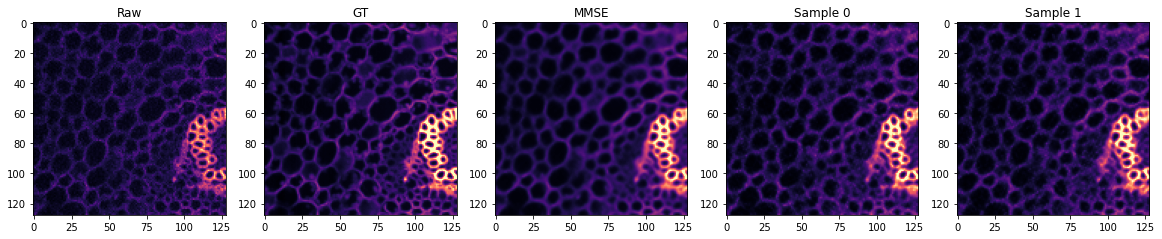

In [6]:
fig=plt.figure(figsize=(20, 10))
gt = signal[0][:128,:128]
vmin=np.percentile(gt,0)
vmax=np.percentile(gt,99)

columns = 5
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(observation[-1][:128,:128],cmap='magma')
plt.title("Raw")
fig.add_subplot(rows, columns, 2)
plt.imshow(gt,vmin=vmin, vmax=vmax,cmap='magma')
plt.title("GT")
fig.add_subplot(rows, columns, 3)
plt.imshow(img_mmse[:128,:128],vmin=vmin, vmax=vmax,cmap='magma')
plt.title("MMSE")
for i in range(4, columns*rows+1):
    img = samples[i][:128,:128]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img,vmin=vmin, vmax=vmax,cmap='magma')
    plt.title("Sample "+str(i-4))
plt.show()